# Evaluation


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../') #act as if we are one directory higher so imports work 
import torch
from latent_to_timestep_model import LTT_model
from dataset import load_data_from_dir
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch import nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import torch.nn.functional as F

In [3]:
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0"
steps = 5
latents, targets, conditions, unconditions, optimal_params = load_data_from_dir(data_folder=path, limit=50, use_optimal_params=True, steps=steps)
#optimal_params



## LD3 Best timesteps


In [4]:
n3_params = torch.tensor([0.6048, 1.0274, 0.6334, 1.8439], device='cuda:0')
n5_params = torch.tensor([0.8088, 1.1801, 0.9390, 0.7322, 0.7591, 2.0050], device='cuda:0')
n7_params = torch.tensor([1.1434, 1.2401, 0.9985, 0.6071, 0.9339, 0.1873, 0.8551, 1.9311], device='cuda:0')
n10_params = torch.tensor([1.6245, 1.3128, 1.5374, 0.6975, 0.8498, 0.9843, 1.3483, 0.6511, 1.1129, 1.2806, 1.6264], device='cuda:0')


n3_params = F.softmax(n3_params, dim=0)
n5_params = F.softmax(n5_params, dim=0)
n7_params = F.softmax(n7_params, dim=0)
n10_params = F.softmax(n10_params, dim=0)

print(f"n3_params:\n{n3_params}")
print(f"n5_params:\n{n5_params}")
print(f"n7_params:\n{n7_params}")
print(f"n10_params:\n{n10_params}")

n3_params:
tensor([0.1427, 0.2178, 0.1468, 0.4927], device='cuda:0')
n5_params:
tensor([0.1140, 0.1652, 0.1298, 0.1056, 0.1084, 0.3770], device='cuda:0')
n7_params:
tensor([0.1300, 0.1432, 0.1124, 0.0760, 0.1054, 0.0500, 0.0974, 0.2857],
       device='cuda:0')
n10_params:
tensor([0.1337, 0.0979, 0.1225, 0.0529, 0.0616, 0.0705, 0.1014, 0.0505, 0.0802,
        0.0948, 0.1340], device='cuda:0')


### LD3 Timesteps Evaluation

In [ ]:
import torch
from torch.nn import functional as F
import time
import os

from dataset import load_data_from_dir
from trainer import LD3Trainer, ModelConfig, TrainingConfig, DiscretizeModelWrapper
from utils import (
    get_solvers,
    parse_arguments,
    adjust_hyper,
    set_seed_everything,
    move_tensor_to_device
)
from models import prepare_stuff

In [ ]:
def evaluate_params(params: torch.tensor) -> float:    
    start_time = time.time()
    args = parse_arguments([
        "--all_config", "configs/cifar10.yml",
        "--data_dir", "train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0",
        "--num_train", "0",
        "--num_valid", "50",
        "--steps", str(len(params)-1),
        "--training_rounds_v1", "1",
        "--seed", "0",
    ])

    set_seed_everything(args.seed)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    wrapped_model, _, decoding_fn, noise_schedule, latent_resolution, latent_channel, _, _ = prepare_stuff(args)
    adjust_hyper(args, latent_resolution, latent_channel)
    solver, steps, solver_extra_params = get_solvers(
        args.solver_name,
        NFEs=args.steps,
        order=args.order,
        noise_schedule=noise_schedule,
        unipc_variant=args.unipc_variant,
    )
    latents, targets, _, _, _ = load_data_from_dir( #this is what we take from trainig, targets are original images and latens latent goal
        data_folder=args.data_dir, limit=args.num_train + args.num_valid, use_optimal_params=False
    )

    training_config = TrainingConfig(
        train_data=latents,
        valid_data=latents,
        train_batch_size=args.main_train_batch_size,
        valid_batch_size=args.main_valid_batch_size,
        lr_time_1=args.lr_time_1,
        shift_lr=args.shift_lr,
        shift_lr_decay=args.shift_lr_decay,
        min_lr_time_1=args.min_lr_time_1,
        win_rate=args.win_rate,
        patient=args.patient,
        lr_time_decay=args.lr_time_decay,
        momentum_time_1=args.momentum_time_1,
        weight_decay_time_1=args.weight_decay_time_1,
        loss_type=args.loss_type,
        visualize=args.visualize,
        no_v1=args.no_v1,
        prior_timesteps=args.gits_ts,
        match_prior=args.match_prior,
    )
    model_config = ModelConfig(
        net=wrapped_model,
        decoding_fn=decoding_fn,
        noise_schedule=noise_schedule,
        solver=solver,
        solver_name=args.solver_name,
        order=args.order,
        steps=steps,
        prior_bound=args.prior_bound,
        resolution=latent_resolution,
        channels=latent_channel,
        time_mode=args.time_mode,
        solver_extra_params=solver_extra_params,
        device=device,
    )
    trainer = LD3Trainer(model_config, training_config)
    dis_model = DiscretizeModelWrapper( #Changed through LTT
            lambda_max=trainer.lambda_max,
            lambda_min=trainer.lambda_min,
            noise_schedule=trainer.noise_schedule,
            time_mode = trainer.time_mode,
        )
    loss_list = torch.zeros(len(targets))
    for i, (img, latent) in enumerate(zip(targets, latents)):
    
        img, latent = move_tensor_to_device(img, latent, device = device)
        
        timestep = dis_model.convert(params.unsqueeze(0))

        x_next = trainer.noise_schedule.prior_transformation(latent)
        x_next = trainer.solver.sample_simple(
            model_fn=trainer.net,
            x=x_next,
            timesteps=timestep[0],
            order=trainer.order,
            NFEs=trainer.steps,
            **trainer.solver_extra_params,
            )
        x_next = trainer.decoding_fn(x_next)
        trainer.loss_vector = trainer.loss_fn(img.float(), x_next.float()).squeeze()
        loss = trainer.loss_vector.mean() 
        loss_list[i] = loss
    print("Time taken: ", time.time() - start_time)
    return loss_list.mean().item()




for name, params in zip(["n3", "n5", "n7", "n10"], [n3_params, n5_params, n7_params, n10_params]):
    print(f"Loss for {name}: {evaluate_params(params)}")

## LTT Model

In [ ]:
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0/final_ltt_model.pt", 10
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train50-rv12-seed0/ltt_model.pt", 10

model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 10
model_path, steps  = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N7-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 7
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N5-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 5
# model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N3-val50-train450-rv12-seed0-fixed_scaling/final_ltt_model.pt", 3
model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_batch3_moreData_N5-val50-train450-r5/final_ltt_model.pt", 5
without_dropout_model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_after_ltt_change_batch1_without_dropout_N5-val50-train450-r10/final_ltt_model.pt", 5
with_dropout_model_path, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/LTT_after_ltt_change_batch1_with_dropout_N5-val50-train450-r10/final_ltt_model.pt", 5
trained_on_optimal_without_dropout, steps = "/netpool/homes/connor/DiffusionModels/LD3_connor/runs/RandomModels/model_lr0.0001_batch5_without_dropout.pth", 5


ltt_model = LTT_model(steps=steps)
state_dict = torch.load(trained_on_optimal_without_dropout, weights_only=True)
ltt_model.load_state_dict(state_dict)  # Load the model state

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(ltt_model))

In [ ]:

params_list = ltt_model.forward(torch.stack(latents)) 

#visualize as violin plot over each of the 10 timesteps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

params_list = params_list.detach().numpy()
params_list = params_list.reshape(-1, steps+1)
params_list = pd.DataFrame(params_list, columns=[f"{i}" for i in range(steps+1)])
sns.violinplot(data=params_list)
plt.show()


In [ ]:
params_list


### U-net encoding

In [ ]:
# Create a dictionary to store the output
hook_storage = {}

# Define the hook function using a closure
def get_hook(storage):
    def hook_fn(module, input, output):
        storage["unet_output"] = output  # Store output in the dictionary
    return hook_fn
# Register the hook on the UNet
hook_handle = ltt_model.unet.register_forward_hook(get_hook(hook_storage))

# Run the forward pass
output = ltt_model.forward(latents[0].unsqueeze(0))

# Retrieve the stored UNet output
unet_output = hook_storage["unet_output"]
print("Stored UNet Output:", unet_output.shape)




In [ ]:
def mse(tensor1, tensor2):
    return torch.mean((tensor1 - tensor2) ** 2)

In [ ]:
encodings = []
num_matrices = 20
for latent in latents[:num_matrices]:
    output = ltt_model.forward(latent.unsqueeze(0))
    encodings.append(hook_storage["unet_output"])


mse_matrix = np.zeros((num_matrices, num_matrices))

for i in range(num_matrices):
    for j in range(num_matrices):
        mse_matrix[i, j] = mse(encodings[i], encodings[j])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mse_matrix, annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()



In [ ]:
encodings[1]

In [ ]:
encodings[2]

## Optimal Timesteps Per Image

In [ ]:
#load from torch.save(loss_matrix, os.path.join(args.data_dir, f"loss_matrix.pt"))
data_dir = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/"
loss_matrix = torch.load(os.path.join(data_dir, f"loss_matrix.pt"))

In [ ]:
loss_matrix

In [ ]:
#plot loss matrix

plt.figure(figsize=(10, 8))
sns.heatmap(loss_matrix, annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()

In [ ]:
#find lowest loss matrix
min_loss = torch.min(loss_matrix, axis=1)
min_loss

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(2):
    min_values = [torch.min(loss_matrix[i, :j+1,]).item() for j in range(300)]
    plt.plot(range(300), min_values, label=f'Line {i+1}')
plt.title("Lowest Value of Second Dimension Up to That Point")
plt.xlabel("Steps")
plt.ylabel("Lowest Value")
plt.legend()
plt.show()

In [ ]:
gradient_matrix = torch.load(os.path.join(data_dir, f"loss_grad_matrix.pt"))
gradient_matrix.shape

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(gradient_matrix[2], annot=False, cmap="viridis", linewidths=0.5)
plt.title("Pairwise MSE Heatmap")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))
for i in range(2):
    plt.plot(range(300), abs(gradient_matrix[1, :, i]), label=f'Line {i+1}')
plt.yscale('log')
plt.title("Gradient Matrix Lines")
plt.xlabel("Steps")
plt.ylabel("Gradient Value (log scale)")
plt.legend()
plt.show()


In [ ]:
test_tensor = torch.tensor([1,2,3,4,5,6], dtype=torch.float32)
test_tensor2 = torch.tensor([1,2,3,4,5,6], dtype=torch.float32)*2
test_tensor3 = torch.tensor([1,2,3,4,5,6], dtype=torch.float32)+1

m = nn.Softmax()
print(m(test_tensor))
print(m(test_tensor2))
print(m(test_tensor3))

### Compare optimal params for different images

In [ ]:
pt_files = [f for f in os.listdir(path) if "optimal_params" in f]
for i, file_name in enumerate(sorted(pt_files)[:]): #load all training files previously created
    file_path = os.path.join(path, file_name)
    params, loss = torch.load(file_path, weights_only=True)
    data = params.detach().numpy()
    losses = loss.detach().numpy()

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)

    # Plot the results
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1],
                        c=losses, cmap='viridis', edgecolor='k', s=100)
    plt.colorbar(scatter, label='Loss')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Visualization Colored by Loss')
    plt.grid(True)
    plt.show()
    print("params\n", data)
    print("losses\n", losses)
    if i > 5:
        break

In [ ]:
pt_files = [f for f in os.listdir(path) if "optimal_params" in f]
pt_files = sorted(pt_files)[:6]  # Load first 6 training files

shapes = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down', 'cross']  # Different marker shapes

all_data = []
best_losses = []



for i, file_name in enumerate(pt_files):
    file_path = os.path.join(path, file_name)
    # Load parameters and loss
    params, loss = torch.load(file_path, weights_only=True)  
    data = params.detach().numpy()
    losses = loss.detach().numpy()
    all_data.append(data)
    best_losses.append(losses)





all_data = np.stack(all_data).reshape(-1, steps+1)
best_losses = np.stack(best_losses).reshape(-1)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_data)
    
# Convert to DataFrame
df = pd.DataFrame(principal_components, columns=["PC1", "PC2"])
df["Loss"] = best_losses
df["Shape"] = [x for x in shapes for _ in range(10)]
df["params"] = list(all_data)
df["params"] = df["params"].apply(lambda x: [round(v, 4) for v in x])

# # Create interactive 3D scatter plot using Plotly
fig = px.scatter(df, x="PC1", y="PC2", color="Loss", symbol="Shape",
                    hover_data={"Loss": ":.4f", "PC1": False, "PC2": False, "params": True},
                    color_continuous_scale="viridis",
                    title="2D PCA Visualization Colored by Loss with Different Shapes")

# Move color bar to the left
fig.update_layout(coloraxis_colorbar=dict(x=-0.2))  

fig.update_traces(marker=dict(size=5, line=dict(width=1, color="black")))

# Show interactive 3D plot
fig.show() 

In [ ]:
pt_files = [f for f in os.listdir(path) if "optimal_params" in f]
pt_files = sorted(pt_files)[:6]  # Load first 6 training files

shapes = ['circle', 'square', 'diamond', 'triangle-up', 'triangle-down', 'cross']  # Different marker shapes

all_data = []
best_losses = []



for i, file_name in enumerate(pt_files):
    file_path = os.path.join(path, file_name)
    # Load parameters and loss
    params, loss = torch.load(file_path, weights_only=True)  
    data = params.detach().numpy()
    losses = loss.detach().numpy()
    all_data.append(data)
    best_losses.append(losses)


all_data = np.stack(all_data).reshape(-1, steps+1)
best_losses = np.stack(best_losses).reshape(-1)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(all_data)
    
# Convert to DataFrame
df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
df["Loss"] = best_losses
df["Shape"] = [x for x in shapes for _ in range(10)]
df["params"] = list(all_data)
df["params"] = df["params"].apply(lambda x: [round(v, 4) for v in x])

# # Create interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Loss", symbol="Shape",
                    hover_data={"Loss": ":.4f", "PC1": False, "PC2": False, "PC3": False, "params": True},
                    color_continuous_scale="viridis",
                    title="3D PCA Visualization Colored by Loss with Different Shapes")

# Move color bar to the left
fig.update_layout(coloraxis_colorbar=dict(x=-0.2))  

fig.update_traces(marker=dict(size=5, line=dict(width=1, color="black")))

# Show interactive 3D plot
fig.show() 

In [ ]:
plt.figure(figsize=(10, 8))
sns.histplot(best_losses, bins=50, kde=True)
plt.title("Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()


#### Only best trial

In [ ]:
pt_files = [f for f in os.listdir(path) if "optimal_params" in f]
pt_files = sorted(pt_files) # Load first 6 training files

all_data = []
best_losses = []
all_losses = []

for i, file_name in enumerate(pt_files):
    file_path = os.path.join(path, file_name)
    # Load parameters and loss
    params, loss = torch.load(file_path, weights_only=True)  
    data = params.detach().numpy()[0]
    losses = loss.detach().numpy()
    all_data.append(data)
    best_losses.append(losses[0])
    all_losses.append(losses)






all_data = np.stack(all_data).reshape(-1, steps+1)
best_losses = np.stack(best_losses).reshape(-1)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(all_data)
    
# Convert to DataFrame
df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
df["Loss"] = best_losses
df["params"] = list(all_data)
df["params"] = df["params"].apply(lambda x: [round(v, 4) for v in x])

# # Create interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df, x="PC1", y="PC2", z="PC3", color="Loss",
                    hover_data={"Loss": ":.4f", "PC1": False, "PC2": False, "PC3": False, "params": True},
                    color_continuous_scale="viridis",
                    title="3D PCA Visualization Colored by Loss with Different Shapes")

# Move color bar to the left
fig.update_layout(coloraxis_colorbar=dict(x=-0.2))  

fig.update_traces(marker=dict(size=5, line=dict(width=1, color="black")))

# Show interactive 3D plot
fig.show()

In [ ]:
#plot loss distribution of all_losses

plt.figure(figsize=(10, 8))
sns.histplot(best_losses, bins=50, kde=True)
plt.title("Loss Distribution")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.show()



In [ ]:
import plotly.graph_objects as go

# Assuming all_losses and best_losses are defined
all_losses = np.stack(all_losses).reshape(-1)

fig = go.Figure()

# Add histogram for all_losses
fig.add_trace(go.Histogram(x=all_losses, nbinsx=75, histnorm='probability density', 
                           name="All Losses", marker_color='blue', opacity=0.5))

# Add histogram for best_losses
fig.add_trace(go.Histogram(x=best_losses, nbinsx=75, histnorm='probability density', 
                           name="Best Losses", marker_color='red', opacity=0.5))

# Update layout
fig.update_layout(
    title="Loss Distribution",
    xaxis_title="Loss",
    yaxis_title="Density",
    barmode='overlay',  # Overlay both histograms
    template="plotly_white"  # Optional: use a clean background
)

fig.show()
print(f"Mean lost of first 50 validation losses: {np.mean(all_losses[:500]):.4f}")
print(f"Mean lost of 50 validation best losses: {np.mean(best_losses[:50]):.4f}")

## Generating latent -> image pairs efficiently in mass

In [1]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Load the PNG image
image_path = '/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/img/000001.png'
image = Image.open(image_path)

# Define a transform to convert the image to a tensor
transform_to_tensor = transforms.ToTensor()

# Apply the transform to the image
tensor = transform_to_tensor(image)

# Verify the tensor shape and type
print(f"Tensor shape: {tensor.shape}")  # Should print: torch.Size([C, H, W])
print(f"Tensor dtype: {tensor.dtype}")  # Should print: torch.float32



Tensor shape: torch.Size([3, 32, 32])
Tensor dtype: torch.float32


In [14]:
tensor_original = torch.load("/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/img_latents/latent_000001.pt")




/tmp/ipykernel_2980688/922970668.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor_original = torch.load("/netpool/homes/connor/DiffusionModels/LD3_connor/train_dat

In [8]:
import PIL
import numpy as np

In [ ]:
# def visualize(tensor: torch.Tensor) -> None:
#     convert =  lambda x: (x + 1.0) / 2.0
#     samples_raw = convert(tensor.unsqueeze(0))
#     samples = np.clip(  #10 because of batch size
#                     samples_raw.permute(0, 2, 3, 1).cpu().numpy() * 255.0, 0, 255
#                 ).astype(np.uint8)
#     image_np = samples.reshape((-1, 32, 32, 3))[0]



#     plt.imshow(image_np)
#     plt.title('Generated Image')
#     plt.axis('off')
#     plt.show()

# PIL.Image.fromarray(image_np, "RGB").save(image_path)

In [17]:
np.sum(image_tensor - image_np)


0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.945513..3.3628078].


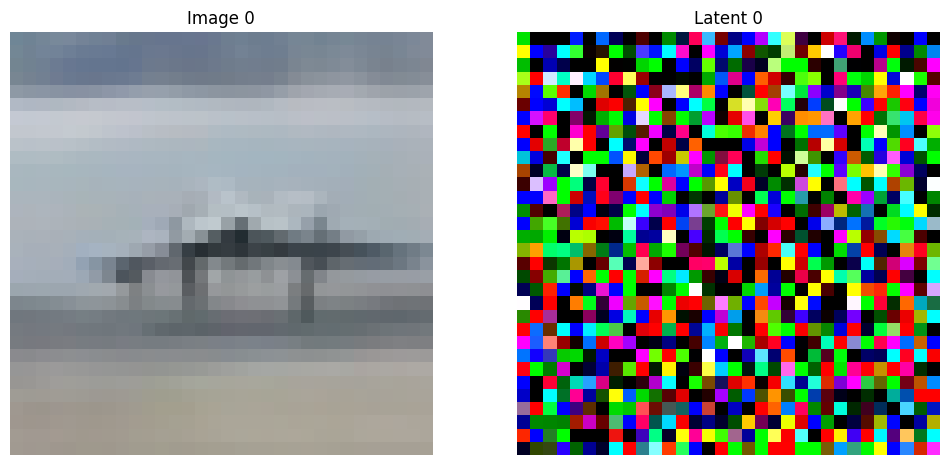

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.945513..3.3628078].


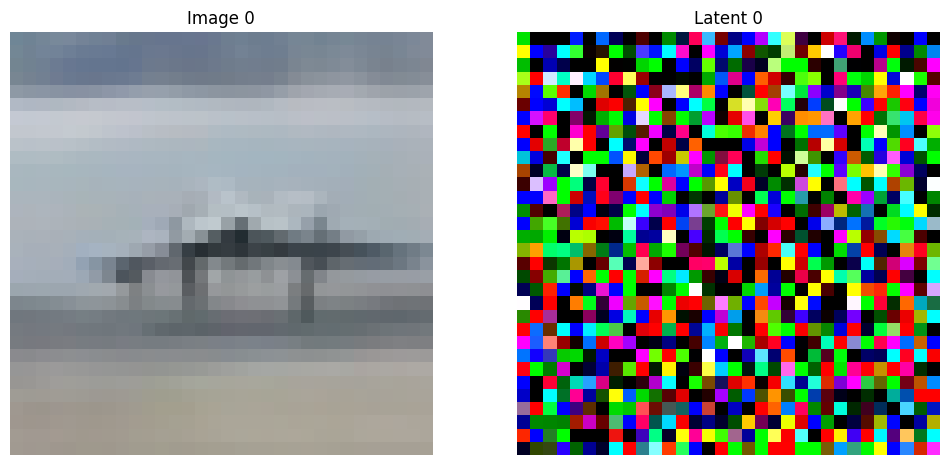

In [7]:
from dataset import LTTDataset
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/validation/img"
dataset = LTTDataset(path)

for i in range(1):
    img, latent = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    plt.show()

# the second output should be exactly the same proving that the data generator working
for i in range(1):
    img, latent = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    plt.show()


In [11]:
dataset[1000]

IndexError: list index out of range

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.945513..3.3628078].


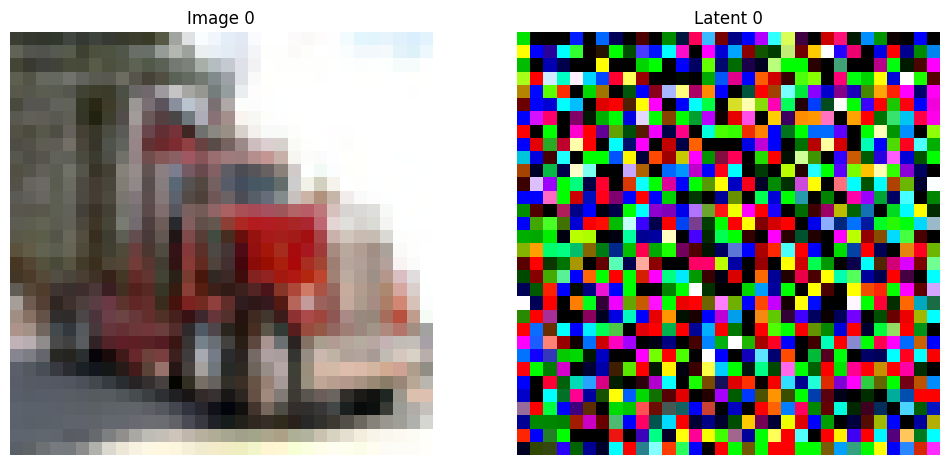

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.945513..3.3628078].


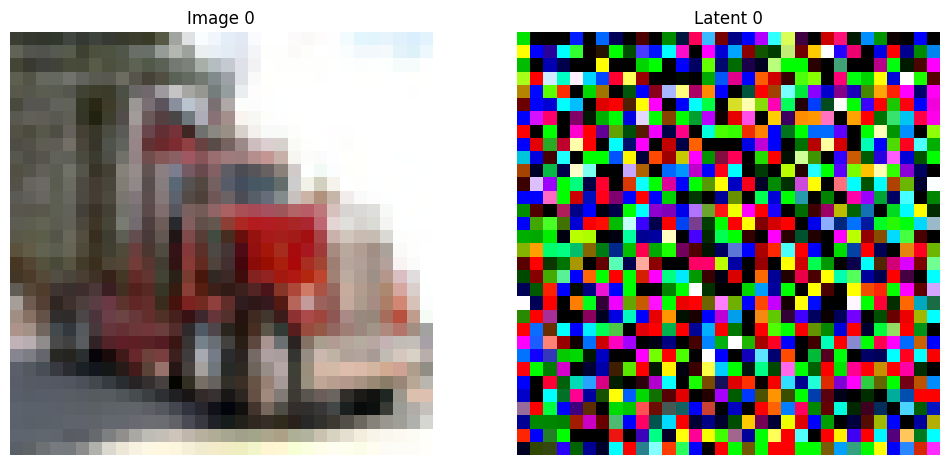

In [5]:
from dataset import LTTDataset
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0/train/img"
dataset = LTTDataset(path)

for i in range(1):
    img, latent = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    plt.show()

# the second output should be exactly the same proving that the data generator working correctly
for i in range(1):
    img, latent = dataset[i]
    # Convert the tensor to a numpy array and transpose the dimensions to match the image format
    img_np = img.permute(1, 2, 0).numpy()
    latent_np = latent.permute(1, 2, 0).numpy()

    # Plot the image and latent side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Image {i}')
    axes[0].axis('off')

    axes[1].imshow(latent_np)
    axes[1].set_title(f'Latent {i}')
    axes[1].axis('off')

    plt.show()
